In [26]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns
import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [27]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [28]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [29]:
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,0,69,0,1,964,3,2,3,3,...,2,5,5,3,5,1,5,3,0,0
1,0,0,55,1,3,240,2,5,5,5,...,2,1,1,2,3,2,3,2,163,0
2,1,0,51,1,3,2672,5,5,5,5,...,1,4,4,4,4,5,4,3,0,1
3,0,1,27,1,1,495,2,3,2,2,...,3,3,4,4,3,4,2,3,0,0
4,0,0,12,0,1,462,2,4,2,3,...,2,2,3,4,2,2,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1,0,49,0,1,1587,3,4,3,4,...,5,4,4,3,5,3,4,5,35,0
5996,1,0,33,0,1,588,2,5,2,3,...,5,5,5,3,5,5,5,5,0,0
5997,0,0,50,0,1,2358,1,4,1,5,...,4,4,4,5,4,4,3,4,0,0
5998,0,0,35,0,1,672,2,3,2,2,...,5,5,1,1,4,4,1,5,0,0


In [30]:
summary = X.describe()

In [31]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [32]:
np.diag(A).sum()

0.0

In [33]:
G = nx.from_numpy_matrix(A)

In [34]:
nx.is_connected(G)

True

In [35]:
features = pd.Series(X.satisfaction) 

In [11]:
pos = nx.spring_layout(G)

In [12]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

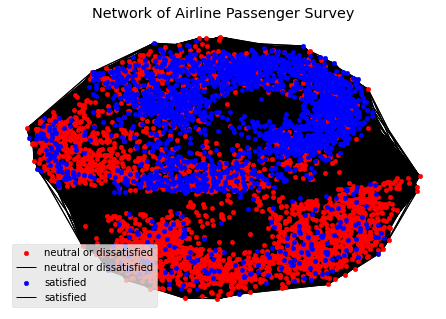

In [13]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

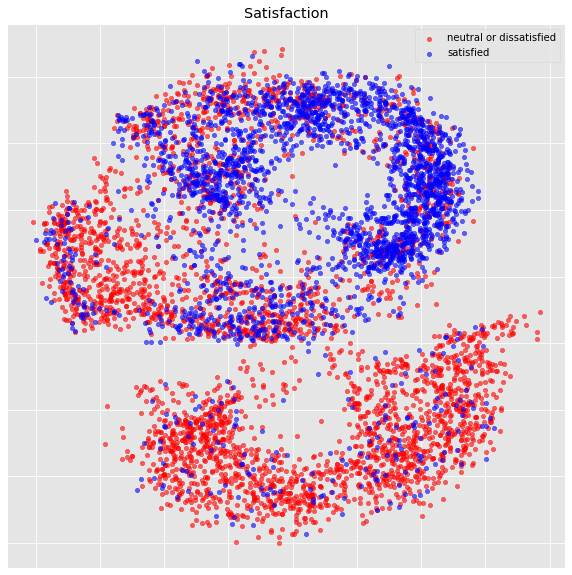

In [14]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

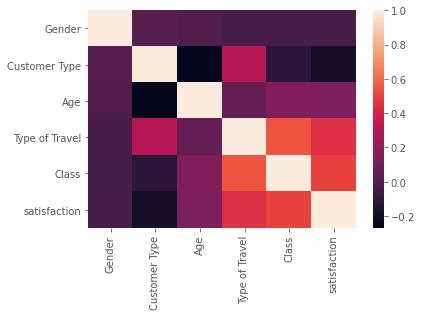

In [15]:
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [16]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

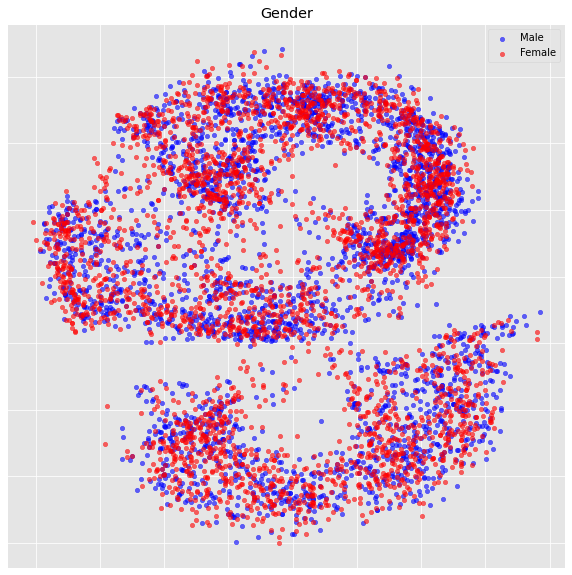

In [17]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [18]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

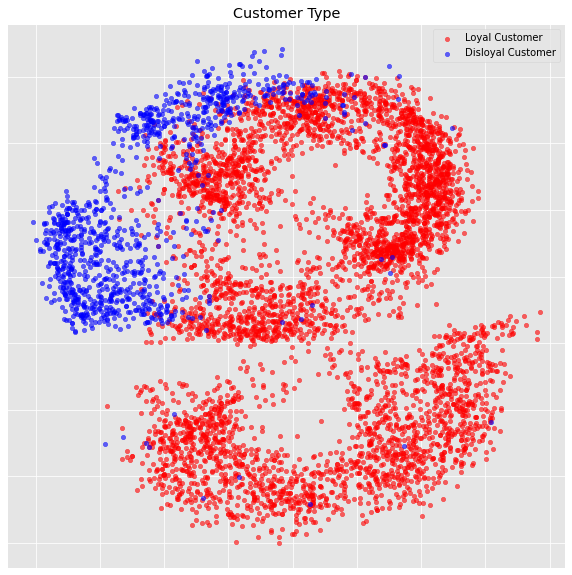

In [19]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [20]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

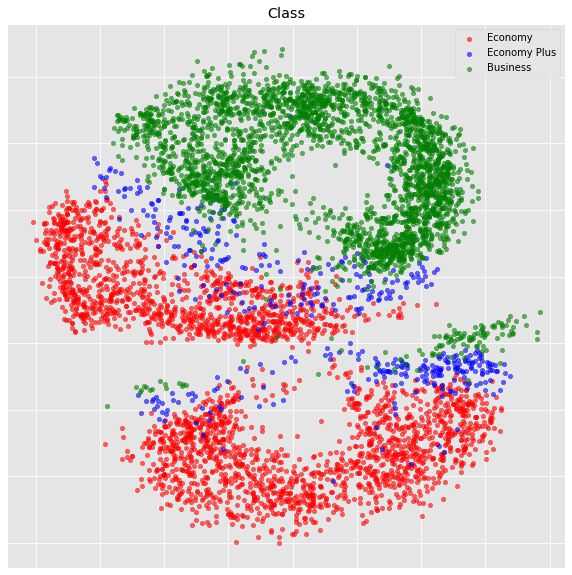

In [21]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [22]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

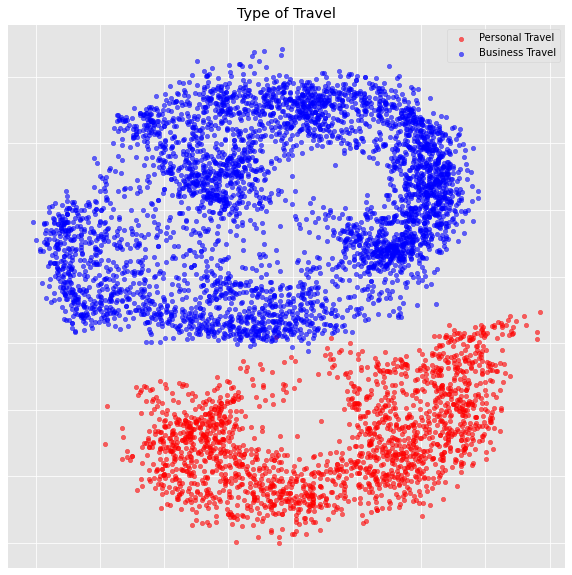

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [24]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [25]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

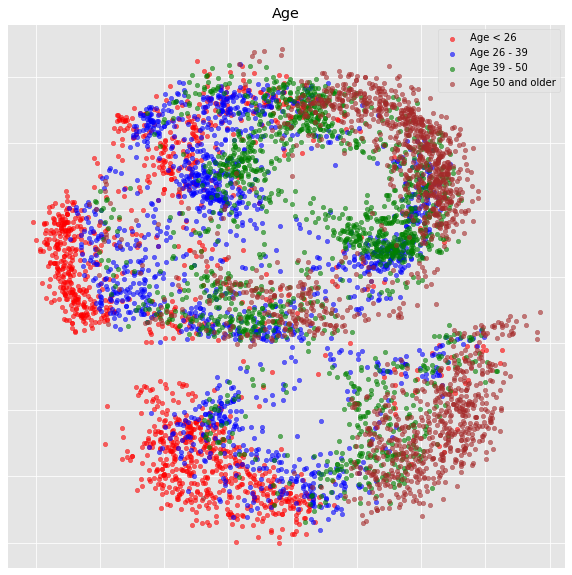

In [26]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

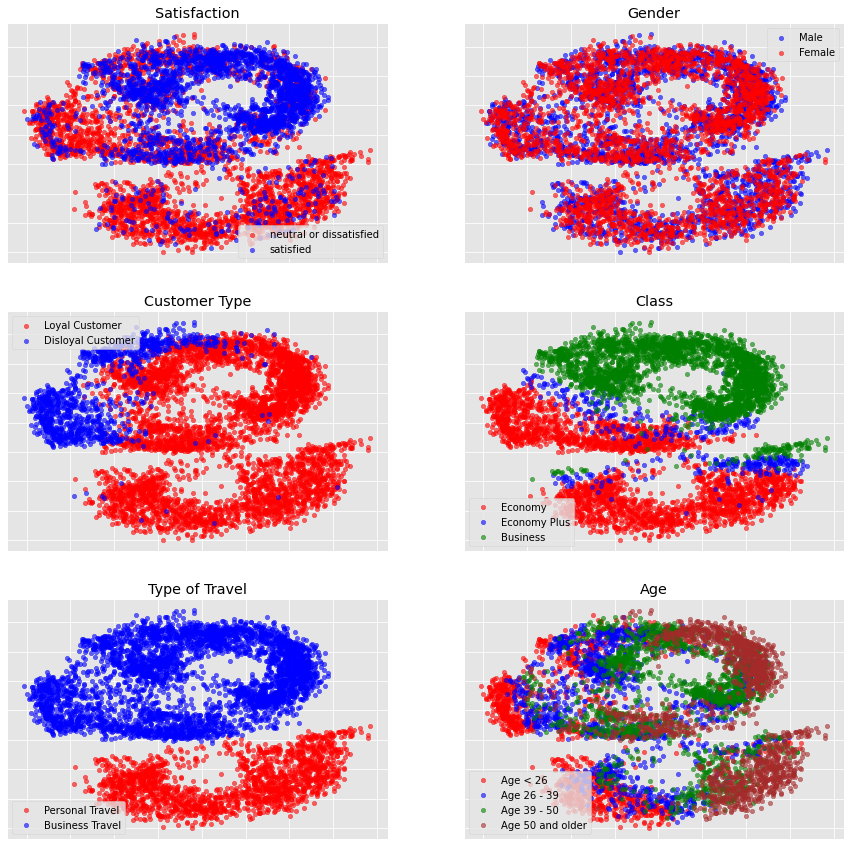

In [27]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


In [49]:
# node2vec train
t = pd.read_csv('embeddings', delimiter = " ", index_col=0, header = None)
t.sort_index(inplace=True)
t = t.to_numpy()
t.shape

(6000, 2)

In [50]:
Z = pd.DataFrame(t,columns = ['x1','x2'])
Z['features'] = features

In [51]:
# node2vec test
t_test = pd.read_csv('embeddings_test', delimiter = " ", index_col=0, header = None)
t_test.sort_index(inplace=True)
t_test = t_test.to_numpy()
t_test.shape

(6000, 2)

In [52]:
Z_test = pd.DataFrame(t_test,columns = ['x1','x2'])
Z_test['features'] = test_features

In [30]:
P = sm.add_constant(t) 
log_reg = sm.Logit(features, P).fit()

Optimization terminated successfully.
         Current function value: 0.517356
         Iterations 6


In [31]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5997
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Jun 2021   Pseudo R-squ.:                  0.2427
Time:                        19:30:40   Log-Likelihood:                -3104.1
converged:                       True   LL-Null:                       -4099.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7051      0.366    -10.135      0.000      -4.422      -2.989
x1             0.9593      0.026     36.244      0.000       0.907       1.011
x2            -3.2333      0.360     -8.992      0.0

In [32]:
predictions = log_reg.predict(P) 

yhat_log = np.empty((len(predictions),1))

for i in range(len(predictions)):
    if predictions[i] < 0.5:
        yhat_log[i] = 0
    else:         
        yhat_log[i] = 1

In [33]:
print('Classification Accuracy validation set {}'.format(accuracy_score(features,yhat_log)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(features,yhat_log))

Classification Accuracy validation set 0.7668333333333334
-------------------------------------------------------------
Confusion Matrix validation set:
[[2612  811]
 [ 588 1989]]


In [53]:
XXXX = x_wd.copy(deep=True)
XXXX['z1'] = Z.x1
XXXX['z2'] = Z.x2
XXXX

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Cleanliness,Departure Delay in Minutes,Customer Type_0,Customer Type_1,Type of Travel_0,Type of Travel_1,Gender_0,Gender_1,z1,z2
0,4.179487,1,1.732843,3,2,3,3,4,3,2,...,3,1.000000,1,0,1,0,0,1,-2.182478,-1.100291
1,3.461538,3,1.141340,2,5,5,5,2,2,2,...,2,2.095798,1,0,0,1,1,0,1.367040,-1.080112
2,3.256410,3,3.128268,5,5,5,5,3,5,1,...,3,1.000000,1,0,0,1,0,1,1.113928,-1.034789
3,2.025641,1,1.349673,2,3,2,2,3,2,3,...,3,1.000000,0,1,0,1,1,0,0.160458,-0.891286
4,1.256410,1,1.322712,2,4,2,3,2,2,2,...,2,1.000000,1,0,1,0,1,0,-2.345489,-1.135601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3.153846,1,2.241830,3,4,3,4,5,4,5,...,5,1.235294,1,0,1,0,0,1,-2.270933,-1.119560
5996,2.333333,1,1.425654,2,5,2,3,5,2,5,...,5,1.000000,1,0,1,0,0,1,-2.452666,-1.176118
5997,3.205128,1,2.871732,1,4,1,5,1,4,4,...,4,1.000000,1,0,1,0,1,0,-2.381334,-1.126160
5998,2.435897,1,1.494281,2,3,2,2,5,2,5,...,5,1.000000,1,0,1,0,1,0,-2.257186,-1.132487


In [54]:
f = pd.get_dummies(features)
#f = pd.get_dummies(X.Class)
x_train, x_test, y_train, y_test = train_test_split(XXXX,f, test_size = 0.2, shuffle=True)

In [55]:
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu'))
#model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=200, batch_size=10)

Epoch 1/200
480/480 [==============================] - 2s 4ms/step - loss: 0.7476 - accuracy: 0.6463 - val_loss: 0.5331 - val_accuracy: 0.7608
Epoch 2/200
480/480 [==============================] - 2s 4ms/step - loss: 0.4604 - accuracy: 0.8076 - val_loss: 0.4219 - val_accuracy: 0.8267
Epoch 3/200
480/480 [==============================] - 1s 2ms/step - loss: 0.3759 - accuracy: 0.8548 - val_loss: 0.3728 - val_accuracy: 0.8425
Epoch 4/200
480/480 [==============================] - 1s 2ms/step - loss: 0.3362 - accuracy: 0.8665 - val_loss: 0.3335 - val_accuracy: 0.8567
Epoch 5/200
480/480 [==============================] - 1s 2ms/step - loss: 0.3042 - accuracy: 0.8805 - val_loss: 0.2954 - val_accuracy: 0.8858
Epoch 6/200
480/480 [==============================] - 1s 3ms/step - loss: 0.2770 - accuracy: 0.8916 - val_loss: 0.2735 - val_accuracy: 0.8867
Epoch 7/200
480/480 [==============================] - 2s 3ms/step - loss: 0.2514 - accuracy: 0.8986 - val_loss: 0.2559 - val_accuracy: 0.8992

Epoch 58/200
480/480 [==============================] - 2s 3ms/step - loss: 0.1164 - accuracy: 0.9548 - val_loss: 0.1369 - val_accuracy: 0.9500
Epoch 59/200
480/480 [==============================] - 1s 3ms/step - loss: 0.1185 - accuracy: 0.9513 - val_loss: 0.1350 - val_accuracy: 0.9467
Epoch 60/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1260 - accuracy: 0.9550 - val_loss: 0.1486 - val_accuracy: 0.9425
Epoch 61/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1194 - accuracy: 0.9517 - val_loss: 0.1559 - val_accuracy: 0.9392
Epoch 62/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1227 - accuracy: 0.9528 - val_loss: 0.1413 - val_accuracy: 0.9442
Epoch 63/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1188 - accuracy: 0.9511 - val_loss: 0.1449 - val_accuracy: 0.9433
Epoch 64/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1262 - accuracy: 0.9498 - val_loss: 0.1381 - val_accuracy:

Epoch 115/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1125 - accuracy: 0.9545 - val_loss: 0.1359 - val_accuracy: 0.9492
Epoch 116/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1143 - accuracy: 0.9554 - val_loss: 0.1306 - val_accuracy: 0.9492
Epoch 117/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1203 - accuracy: 0.9559 - val_loss: 0.1320 - val_accuracy: 0.9458
Epoch 118/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1226 - accuracy: 0.9574 - val_loss: 0.1298 - val_accuracy: 0.9517
Epoch 119/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1130 - accuracy: 0.9505 - val_loss: 0.1420 - val_accuracy: 0.9542
Epoch 120/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1133 - accuracy: 0.9579 - val_loss: 0.1316 - val_accuracy: 0.9500
Epoch 121/200
480/480 [==============================] - 1s 2ms/step - loss: 0.1173 - accuracy: 0.9546 - val_loss: 0.1313 - val_ac

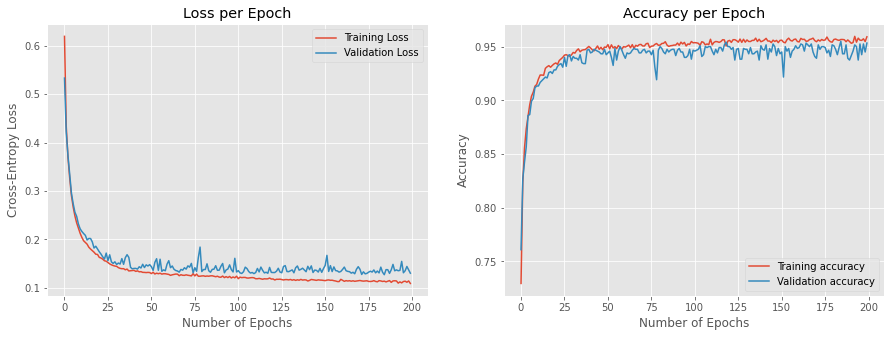

In [56]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [62]:
yy_test = pd.get_dummies(yy)
yy_tf = tf.convert_to_tensor(yy_test)
TTTTTT = XXXX = xx_dummy.copy(deep=True)
TTTTTT['z1'] = Z_test.x1
TTTTTT['z2'] = Z_test.x2
TT_tf = tf.convert_to_tensor(TTTTTT)
results = model.evaluate(TT_tf, yy_test)
print("test loss, test acc:", results)

188/188 [==============================] - 1s 3ms/step - loss: 0.2838 - accuracy: 0.8827
test loss, test acc: [0.2837865948677063, 0.8826666474342346]


In [65]:
TTTTTT

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Cleanliness,Departure Delay in Minutes,Customer Type_0,Customer Type_1,Type of Travel_0,Type of Travel_1,Gender_0,Gender_1,z1,z2
0,1.871795,1,1.731018,5,5,5,4,2,5,1,...,2,1.000000,0,1,0,1,0,1,1.263135,0.618403
1,3.153846,3,3.636511,3,3,3,3,2,5,5,...,5,1.161209,1,0,0,1,1,0,1.227722,0.551899
2,2.128205,1,1.367528,1,3,1,3,3,1,3,...,3,1.000000,0,1,0,1,0,1,0.637869,-0.539068
3,3.564103,3,2.752827,2,2,3,2,1,2,5,...,4,1.050378,1,0,0,1,0,1,0.713818,-0.362981
4,1.871795,1,1.739095,2,2,2,3,4,2,4,...,4,1.000000,0,1,0,1,0,1,0.987218,0.193263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2.025641,3,1.220517,2,2,2,5,4,2,4,...,4,1.090680,0,1,0,1,0,1,0.531026,-0.869078
5996,4.230769,1,1.348142,5,5,5,3,1,4,2,...,2,1.000000,1,0,1,0,0,1,1.252779,0.602329
5997,2.538462,3,2.914378,2,2,2,2,5,3,1,...,5,1.473552,1,0,0,1,1,0,0.986113,0.201152
5998,1.512821,1,1.668821,4,5,3,4,1,3,1,...,1,1.000000,1,0,1,0,1,0,1.264823,0.629945


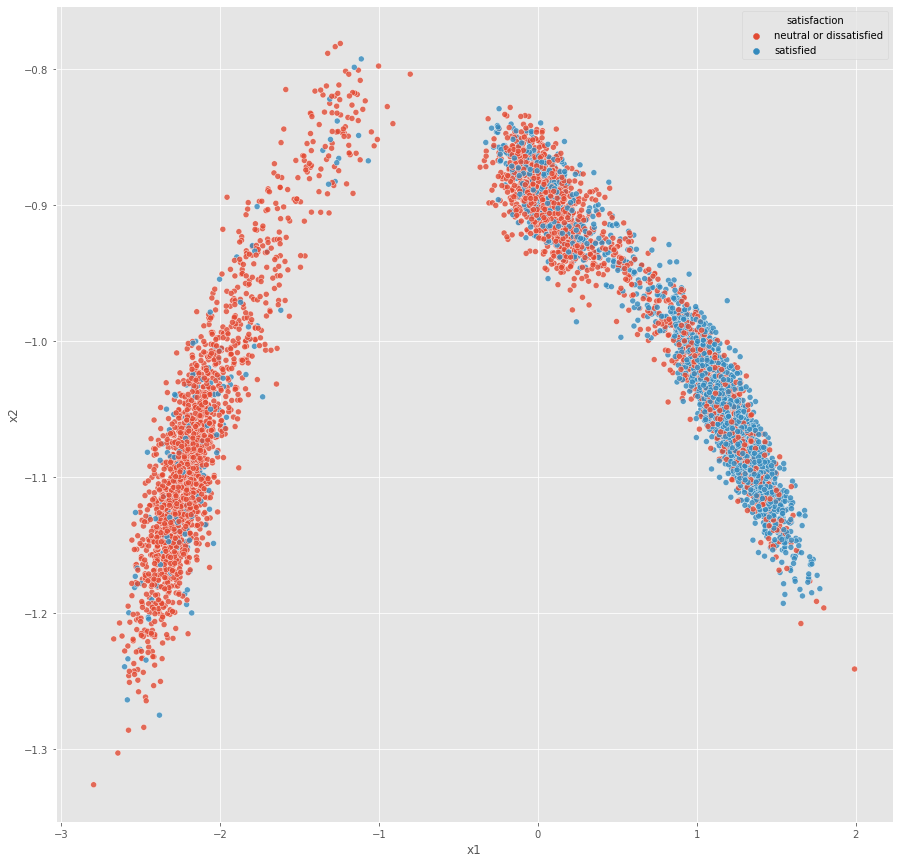

In [36]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=Z.x1,y=Z.x2,hue=df['satisfaction'],alpha=0.8)
plt.show()

In [36]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

normalize(X[['Age','Departure Delay in Minutes','Flight Distance']]).describe()

,Age,Departure Delay in Minutes,Flight Distance
count,6000.000000,6000.000000,6000.000000
mean,2.646205,1.099554,1.923561
std,0.778099,0.254016,0.812036
min,1.000000,1.000000,1.000000
25%,2.025641,1.000000,1.292484
50%,2.692308,1.000000,1.648693
75%,3.205128,1.080672,2.360498
max,5.000000,5.000000,5.000000


In [37]:
G_dgl = dgl.from_networkx(G)
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [38]:
x_wd

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Customer Type_0,Customer Type_1,Type of Travel_0,Type of Travel_1,Gender_0,Gender_1
0,4.179487,1,1.732843,3,2,3,3,4,3,2,...,1,5,3,1.000000,1,0,1,0,0,1
1,3.461538,3,1.141340,2,5,5,5,2,2,2,...,2,3,2,2.095798,1,0,0,1,1,0
2,3.256410,3,3.128268,5,5,5,5,3,5,1,...,5,4,3,1.000000,1,0,0,1,0,1
3,2.025641,1,1.349673,2,3,2,2,3,2,3,...,4,2,3,1.000000,0,1,0,1,1,0
4,1.256410,1,1.322712,2,4,2,3,2,2,2,...,2,1,2,1.000000,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3.153846,1,2.241830,3,4,3,4,5,4,5,...,3,4,5,1.235294,1,0,1,0,0,1
5996,2.333333,1,1.425654,2,5,2,3,5,2,5,...,5,5,5,1.000000,1,0,1,0,0,1
5997,3.205128,1,2.871732,1,4,1,5,1,4,4,...,4,3,4,1.000000,1,0,1,0,1,0
5998,2.435897,1,1.494281,2,3,2,2,5,2,5,...,4,1,5,1.000000,1,0,1,0,1,0


In [96]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [187]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [188]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [189]:
len(train_nids)

4798

In [190]:
len(valid_nids)

1202

In [191]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [192]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([3088, 1379, 4277,  ..., 4535, 4727, 4495]), tensor([3088, 1379, 4277, 4897, 2739,  546,  158, 1432, 2870, 4031, 4249, 1526,
        5720, 1419, 4747,  917, 2137, 4970, 3520, 2104,  259, 3831, 4730, 5225,
        1216, 3974, 3182, 4729, 3696, 3263, 5913, 3335, 1592, 2897,  731, 4794,
        4466, 3850, 3553, 3404, 3878, 1714, 2111, 1851, 2479,  269, 3456, 1384,
        2132,  841]), [Block(num_src_nodes=2483, num_dst_nodes=533, num_edges=2665), Block(num_src_nodes=533, num_dst_nodes=50, num_edges=500)]]


In [193]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2483 nodes' input features


In [194]:
print(bipartites)

[Block(num_src_nodes=2483, num_dst_nodes=533, num_edges=2665), Block(num_src_nodes=533, num_dst_nodes=50, num_edges=500)]


In [195]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [196]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

In [197]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [198]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.LogSoftmax(dim=1)))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [199]:
model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
#model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='lstm') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)

In [200]:
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        predictions = model(bipartites, inputs)

        loss = F.cross_entropy(predictions, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training ⁄Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(model(bipartites, inputs).argmax(1).numpy())
            valid_pred = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_pred, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.643, Training Loss: 0.632
Epoch: 0, Validation Accuracy: 0.703, Validation Loss: 0.583, Time: 1.7677
Epoch: 1, Training Accuracy: 0.702, Training Loss: 0.589
Epoch: 1, Validation Accuracy: 0.729, Validation Loss: 0.556, Time: 1.7586
Epoch: 2, Training Accuracy: 0.716, Training Loss: 0.573
Epoch: 2, Validation Accuracy: 0.735, Validation Loss: 0.565, Time: 1.8086
Epoch: 3, Training Accuracy: 0.740, Training Loss: 0.556
Epoch: 3, Validation Accuracy: 0.765, Validation Loss: 0.536, Time: 1.8762
Epoch: 4, Training Accuracy: 0.772, Training Loss: 0.533
Epoch: 4, Validation Accuracy: 0.796, Validation Loss: 0.517, Time: 1.8381
Epoch: 5, Training Accuracy: 0.791, Training Loss: 0.517
Epoch: 5, Validation Accuracy: 0.795, Validation Loss: 0.510, Time: 1.8013
Epoch: 6, Training Accuracy: 0.808, Training Loss: 0.504
Epoch: 6, Validation Accuracy: 0.831, Validation Loss: 0.483, Time: 1.7750
Epoch: 7, Training Accuracy: 0.839, Training Loss: 0.476
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.904, Training Loss: 0.407
Epoch: 62, Validation Accuracy: 0.905, Validation Loss: 0.403, Time: 2.1455
Epoch: 63, Training Accuracy: 0.906, Training Loss: 0.405
Epoch: 63, Validation Accuracy: 0.908, Validation Loss: 0.404, Time: 2.1351
Epoch: 64, Training Accuracy: 0.910, Training Loss: 0.402
Epoch: 64, Validation Accuracy: 0.908, Validation Loss: 0.401, Time: 2.1324
Epoch: 65, Training Accuracy: 0.908, Training Loss: 0.404
Epoch: 65, Validation Accuracy: 0.909, Validation Loss: 0.400, Time: 2.1172
Epoch: 66, Training Accuracy: 0.909, Training Loss: 0.403
Epoch: 66, Validation Accuracy: 0.910, Validation Loss: 0.401, Time: 2.1111
Epoch: 67, Training Accuracy: 0.912, Training Loss: 0.400
Epoch: 67, Validation Accuracy: 0.913, Validation Loss: 0.399, Time: 2.1061
Epoch: 68, Training Accuracy: 0.917, Training Loss: 0.395
Epoch: 68, Validation Accuracy: 0.917, Validation Loss: 0.397, Time: 2.1166
Epoch: 69, Training Accuracy: 0.909, Training Loss: 0.402
Epoc

Epoch: 123, Training Accuracy: 0.924, Training Loss: 0.387
Epoch: 123, Validation Accuracy: 0.911, Validation Loss: 0.399, Time: 2.2484
Epoch: 124, Training Accuracy: 0.925, Training Loss: 0.387
Epoch: 124, Validation Accuracy: 0.921, Validation Loss: 0.389, Time: 2.2472
Epoch: 125, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 125, Validation Accuracy: 0.924, Validation Loss: 0.388, Time: 2.2602
Epoch: 126, Training Accuracy: 0.927, Training Loss: 0.387
Epoch: 126, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 2.2626
Epoch: 127, Training Accuracy: 0.924, Training Loss: 0.388
Epoch: 127, Validation Accuracy: 0.918, Validation Loss: 0.391, Time: 2.2593
Epoch: 128, Training Accuracy: 0.922, Training Loss: 0.391
Epoch: 128, Validation Accuracy: 0.928, Validation Loss: 0.386, Time: 2.2563
Epoch: 129, Training Accuracy: 0.925, Training Loss: 0.385
Epoch: 129, Validation Accuracy: 0.927, Validation Loss: 0.385, Time: 2.2528
Epoch: 130, Training Accuracy: 0.919, Training L

Epoch: 184, Training Accuracy: 0.930, Training Loss: 0.381
Epoch: 184, Validation Accuracy: 0.937, Validation Loss: 0.374, Time: 2.1442
Epoch: 185, Training Accuracy: 0.940, Training Loss: 0.373
Epoch: 185, Validation Accuracy: 0.936, Validation Loss: 0.375, Time: 2.1414
Epoch: 186, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 186, Validation Accuracy: 0.927, Validation Loss: 0.387, Time: 2.1390
Epoch: 187, Training Accuracy: 0.934, Training Loss: 0.378
Epoch: 187, Validation Accuracy: 0.943, Validation Loss: 0.372, Time: 2.1414
Epoch: 188, Training Accuracy: 0.936, Training Loss: 0.377
Epoch: 188, Validation Accuracy: 0.922, Validation Loss: 0.389, Time: 2.1434
Epoch: 189, Training Accuracy: 0.931, Training Loss: 0.381
Epoch: 189, Validation Accuracy: 0.933, Validation Loss: 0.385, Time: 2.1466
Epoch: 190, Training Accuracy: 0.934, Training Loss: 0.380
Epoch: 190, Validation Accuracy: 0.934, Validation Loss: 0.379, Time: 2.1524
Epoch: 191, Training Accuracy: 0.941, Training L

Epoch: 245, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 245, Validation Accuracy: 0.940, Validation Loss: 0.370, Time: 2.1813
Epoch: 246, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 246, Validation Accuracy: 0.938, Validation Loss: 0.373, Time: 2.1797
Epoch: 247, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 247, Validation Accuracy: 0.934, Validation Loss: 0.375, Time: 2.1779
Epoch: 248, Training Accuracy: 0.938, Training Loss: 0.374
Epoch: 248, Validation Accuracy: 0.937, Validation Loss: 0.373, Time: 2.1769
Epoch: 249, Training Accuracy: 0.940, Training Loss: 0.372
Epoch: 249, Validation Accuracy: 0.935, Validation Loss: 0.377, Time: 2.1758
Epoch: 250, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 250, Validation Accuracy: 0.938, Validation Loss: 0.372, Time: 2.1741
Epoch: 251, Training Accuracy: 0.935, Training Loss: 0.377
Epoch: 251, Validation Accuracy: 0.938, Validation Loss: 0.374, Time: 2.1729
Epoch: 252, Training Accuracy: 0.940, Training L

Epoch: 306, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 306, Validation Accuracy: 0.940, Validation Loss: 0.373, Time: 2.1743
Epoch: 307, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 307, Validation Accuracy: 0.950, Validation Loss: 0.365, Time: 2.1715
Epoch: 308, Training Accuracy: 0.943, Training Loss: 0.370
Epoch: 308, Validation Accuracy: 0.948, Validation Loss: 0.367, Time: 2.1700
Epoch: 309, Training Accuracy: 0.942, Training Loss: 0.370
Epoch: 309, Validation Accuracy: 0.943, Validation Loss: 0.370, Time: 2.1690
Epoch: 310, Training Accuracy: 0.946, Training Loss: 0.366
Epoch: 310, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.1680
Epoch: 311, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 311, Validation Accuracy: 0.941, Validation Loss: 0.371, Time: 2.1670
Epoch: 312, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 312, Validation Accuracy: 0.947, Validation Loss: 0.369, Time: 2.1643
Epoch: 313, Training Accuracy: 0.944, Training L

Epoch: 367, Training Accuracy: 0.945, Training Loss: 0.369
Epoch: 367, Validation Accuracy: 0.942, Validation Loss: 0.370, Time: 2.1257
Epoch: 368, Training Accuracy: 0.942, Training Loss: 0.371
Epoch: 368, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.1249
Epoch: 369, Training Accuracy: 0.939, Training Loss: 0.371
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.369, Time: 2.1238
Epoch: 370, Training Accuracy: 0.943, Training Loss: 0.369
Epoch: 370, Validation Accuracy: 0.943, Validation Loss: 0.369, Time: 2.1230
Epoch: 371, Training Accuracy: 0.946, Training Loss: 0.367
Epoch: 371, Validation Accuracy: 0.945, Validation Loss: 0.369, Time: 2.1223
Epoch: 372, Training Accuracy: 0.943, Training Loss: 0.371
Epoch: 372, Validation Accuracy: 0.938, Validation Loss: 0.375, Time: 2.1213
Epoch: 373, Training Accuracy: 0.947, Training Loss: 0.366
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.365, Time: 2.1206
Epoch: 374, Training Accuracy: 0.942, Training L

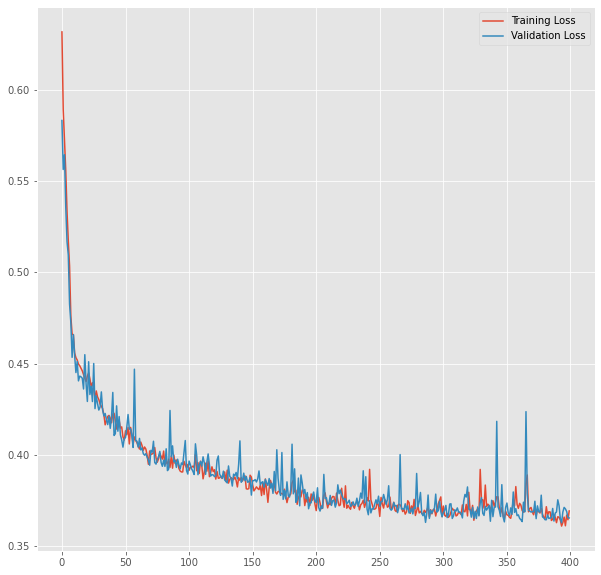

In [201]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

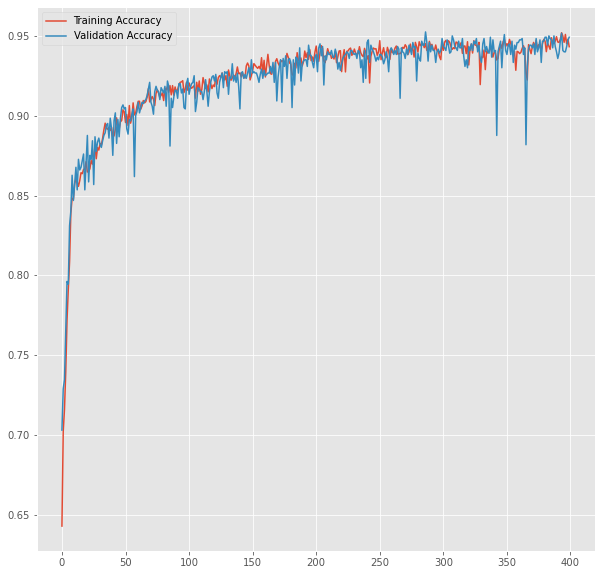

In [202]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [203]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9433159722222219
Validation Accuracy: 0.9492512479201332


In [204]:
np.argmax(valid_acc)

286

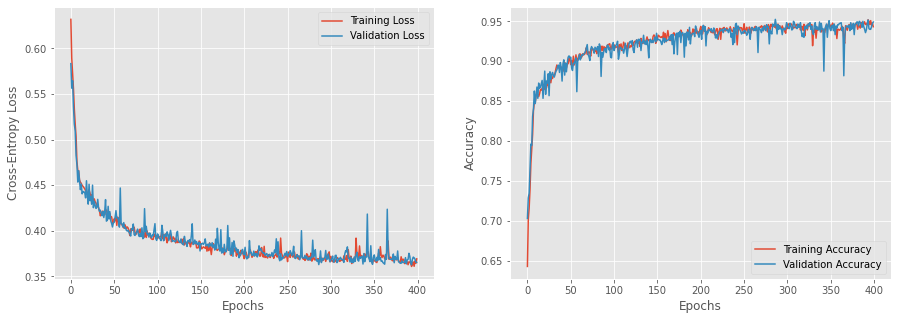

In [205]:
fig = plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [206]:
model.parameters

<bound method Module.parameters of SumSAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): LogSoftmax(dim=1)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

In [39]:
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [40]:
TEST = df_test.copy(deep=True)

In [41]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [42]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [65]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [66]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [67]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [68]:
A = A + A.T

In [69]:
G_test = nx.from_numpy_matrix(A)

In [43]:
test_features = pd.Series(TEST.satisfaction)

In [44]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

NameError: name 'G_test' is not defined

In [207]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [208]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

In [209]:
model.load_state_dict(torch.load('model_preprocc.pt'))
all_predictions = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


In [210]:
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9416666666666667


In [211]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9416666666666667
-------------------------------------------------------------
Confusion Matrix test set:
[[3218  138]
 [ 212 2432]]


In [212]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9416666666666667

In [47]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

In [267]:
f = pd.get_dummies(features)
x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
#model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
#model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=250, batch_size=10)

Epoch 1/250
480/480 [==============================] - 2s 2ms/step - loss: 0.7270 - accuracy: 0.6219 - val_loss: 0.4328 - val_accuracy: 0.8367
Epoch 2/250
480/480 [==============================] - 1s 2ms/step - loss: 0.4335 - accuracy: 0.8200 - val_loss: 0.3414 - val_accuracy: 0.8750
Epoch 3/250
480/480 [==============================] - 1s 2ms/step - loss: 0.3495 - accuracy: 0.8658 - val_loss: 0.2872 - val_accuracy: 0.9000
Epoch 4/250
480/480 [==============================] - 1s 2ms/step - loss: 0.2969 - accuracy: 0.8776 - val_loss: 0.2527 - val_accuracy: 0.9025
Epoch 5/250
480/480 [==============================] - 1s 2ms/step - loss: 0.2475 - accuracy: 0.9000 - val_loss: 0.2140 - val_accuracy: 0.9133
Epoch 6/250
480/480 [==============================] - 1s 2ms/step - loss: 0.2387 - accuracy: 0.9047 - val_loss: 0.1916 - val_accuracy: 0.9308
Epoch 7/250
480/480 [==============================] - 1s 2ms/step - loss: 0.2130 - accuracy: 0.9129 - val_loss: 0.1841 - val_accuracy: 0.9325

Epoch 58/250
480/480 [==============================] - 1s 1ms/step - loss: 0.1175 - accuracy: 0.9597 - val_loss: 0.1475 - val_accuracy: 0.9383
Epoch 59/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1034 - accuracy: 0.9595 - val_loss: 0.1521 - val_accuracy: 0.9358
Epoch 60/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1185 - accuracy: 0.9505 - val_loss: 0.1492 - val_accuracy: 0.9450
Epoch 61/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1202 - accuracy: 0.9499 - val_loss: 0.1476 - val_accuracy: 0.9458
Epoch 62/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1121 - accuracy: 0.9555 - val_loss: 0.1393 - val_accuracy: 0.9467
Epoch 63/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9560 - val_loss: 0.1492 - val_accuracy: 0.9467
Epoch 64/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1137 - accuracy: 0.9548 - val_loss: 0.1538 - val_accuracy:

Epoch 115/250
480/480 [==============================] - 1s 2ms/step - loss: 0.0995 - accuracy: 0.9634 - val_loss: 0.1551 - val_accuracy: 0.9425
Epoch 116/250
480/480 [==============================] - 1s 2ms/step - loss: 0.1046 - accuracy: 0.9581 - val_loss: 0.1488 - val_accuracy: 0.9458
Epoch 117/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0981 - accuracy: 0.9615 - val_loss: 0.1554 - val_accuracy: 0.9433
Epoch 118/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9613 - val_loss: 0.1574 - val_accuracy: 0.9417
Epoch 119/250
480/480 [==============================] - 1s 2ms/step - loss: 0.0987 - accuracy: 0.9622 - val_loss: 0.1442 - val_accuracy: 0.9508
Epoch 120/250
480/480 [==============================] - 1s 2ms/step - loss: 0.0972 - accuracy: 0.9616 - val_loss: 0.1477 - val_accuracy: 0.9492
Epoch 121/250
480/480 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9574 - val_loss: 0.1515 - val_ac

480/480 [==============================] - 1s 2ms/step - loss: 0.0848 - accuracy: 0.9651 - val_loss: 0.1617 - val_accuracy: 0.9333
Epoch 228/250
480/480 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9620 - val_loss: 0.1652 - val_accuracy: 0.9467
Epoch 229/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0944 - accuracy: 0.9600 - val_loss: 0.1561 - val_accuracy: 0.9367
Epoch 230/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0828 - accuracy: 0.9677 - val_loss: 0.1614 - val_accuracy: 0.9425
Epoch 231/250
480/480 [==============================] - 2s 3ms/step - loss: 0.0930 - accuracy: 0.9611 - val_loss: 0.1493 - val_accuracy: 0.9483
Epoch 232/250
480/480 [==============================] - 2s 3ms/step - loss: 0.0845 - accuracy: 0.9660 - val_loss: 0.1529 - val_accuracy: 0.9433
Epoch 233/250
480/480 [==============================] - 1s 3ms/step - loss: 0.0931 - accuracy: 0.9638 - val_loss: 0.1626 - val_accuracy: 0.9342

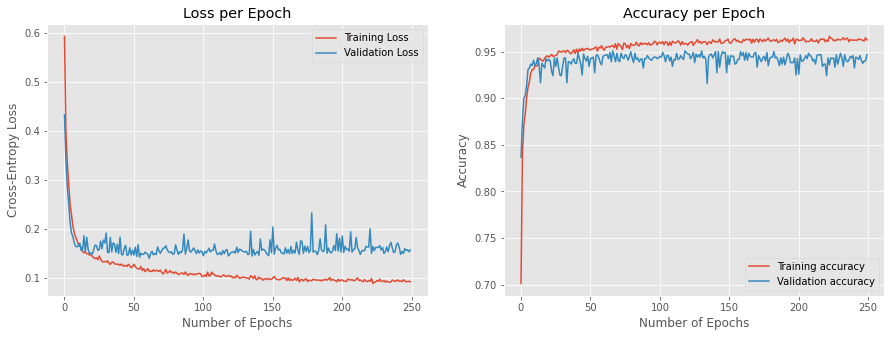

In [271]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [270]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

  1/188 [..............................] - ETA: 12s

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


188/188 [==============================] - 0s 2ms/step
test loss, test acc: [0.17735151946544647, 0.9331666827201843]


In [83]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9441666666666667
0.935


In [84]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [85]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

0.9245
0.9245


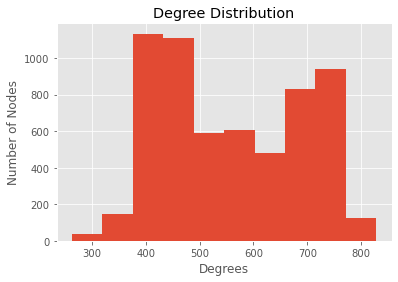

In [86]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title('Degree Distribution')
    plt.xlabel('Degrees')
    plt.ylabel('Number of Nodes')
    plt.show()
    
plot_degree_dist(G)

In [87]:
G.number_of_edges()

1678903

In [88]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

<ipython-input-88-ecdc1502b742>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


1.0
0.9508333333333333


In [89]:
y_pred = clf.predict(xx_dummy)
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.9438333333333333
0.9352794315344729


In [90]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9354166666666667
0.9308333333333333
0.9245
0.9126999421853922


In [91]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.8745833333333334
0.8583333333333333
0.856
0.833718244803695


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [92]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))
print(clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8816666666666667
0.8708333333333333
0.8643333333333333
0.8429783950617283


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
